# Пакети/модулі та їх опції

In [1]:
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import Sequential
# from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
# from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import time

%matplotlib inline

# Константи

In [2]:
IMG_ROWS, IMG_COLS = 28, 28
RANDOM_STATE = int(time.time()) - 23-10-2023
EPOCHS_AMO, BATCH_SIZE = 23, 128
VALID_SIZE = 0.2
SAVED_BEST_MODEL = "best_like_vgg16_model.hdf5"
CLASS_NAMES = ['Футболка', 'Брюки', 'Пуловер', 'Плаття', 'Пальто',
               'Босоніжка','Сорочка', 'Кросівка', 'Сумка', 'Черевик']
BAD_TEST_CASES=[1662,2311,2478,2659,3327,3918,5520,5037,6024,7024,7369,7800,8465,8804,9590]

# Дейтасет

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print("Amount images in training set {}".format(x_train.shape))
print("Amount labels in training set {}".format(y_train.shape))
print("Amount images in test set {}".format(x_test.shape))
print("Amount labels in test set {}".format(y_train.shape))

Amount images in training set (60000, 28, 28)
Amount labels in training set (60000,)
Amount images in test set (10000, 28, 28)
Amount labels in test set (60000,)


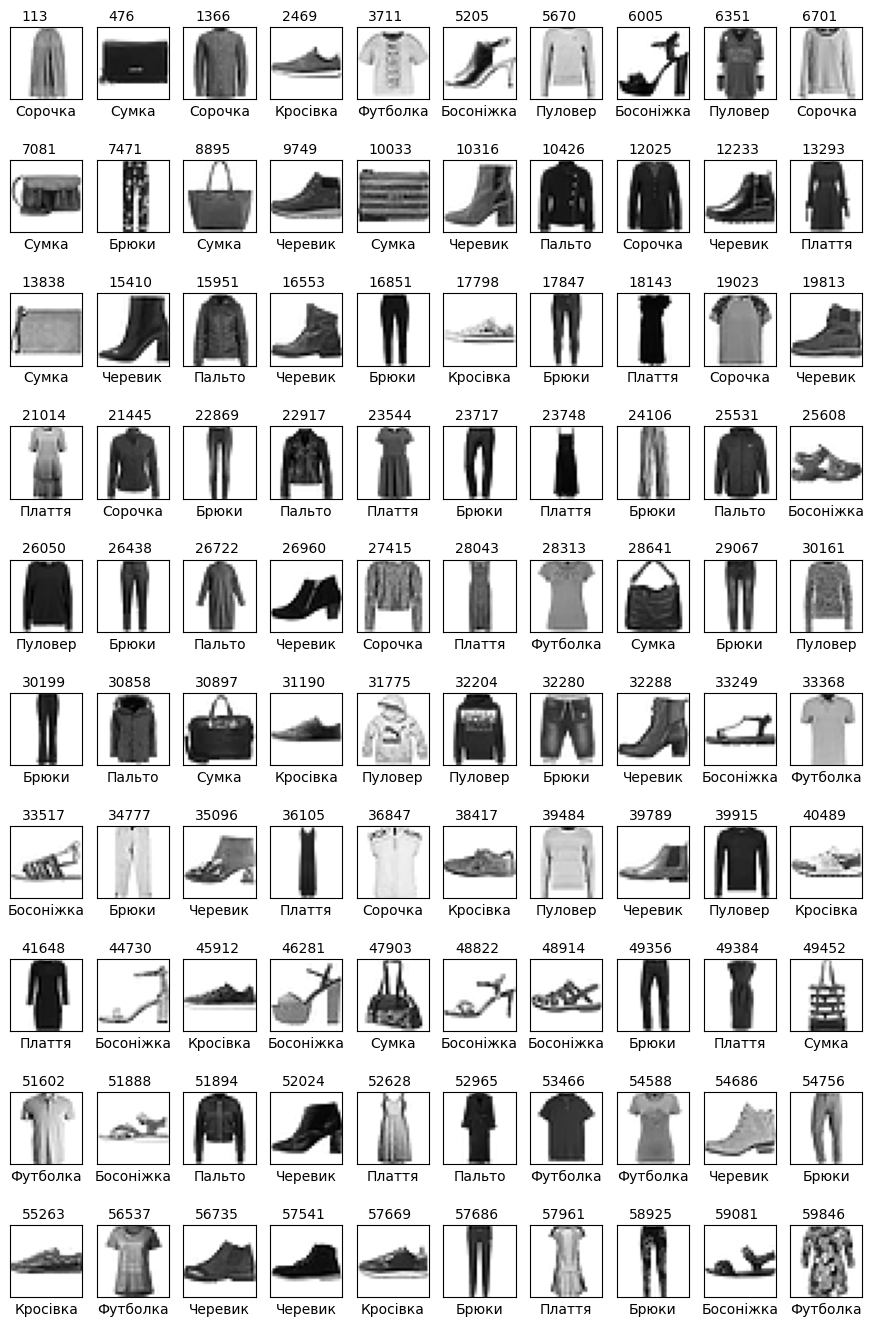

In [4]:
plt.figure(figsize=(11,17))
i = 0
for ind in np.sort(np.random.randint(0, x_train.shape[0], size=100, dtype=int)):
    i += 1
    plt.subplot(10,10,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[ind], cmap='binary')
    plt.xlabel(CLASS_NAMES[y_train[ind]])
    plt.text(x=4, y=-3, s=ind)
plt.show()

# Створення CNN

## Підготовка даних

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Виділяється частка для валідації
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=VALID_SIZE,
                                                      random_state=RANDOM_STATE)

# x_train = np.concatenate((x_train, x_test[BAD_TEST_CASES]))
# y_train = np.concatenate((y_train, y_test[BAD_TEST_CASES]))

# Додається додатковий вимір
x_train = x_train.reshape(x_train.shape[0], IMG_ROWS, IMG_COLS, 1)
x_valid = x_valid.reshape(x_valid.shape[0], IMG_ROWS, IMG_COLS, 1)
x_test = x_test.reshape(x_test.shape[0], IMG_ROWS, IMG_COLS, 1)

# Зображення нормалізуються так, щоб піксели були масштабно відображені в діапазоні [0,1]
(x_train, x_valid, x_test) = (tf.cast(x_train/255.0, tf.float32),
                              tf.cast(x_valid/255.0, tf.float32),
                              tf.cast(x_test/255.0, tf.float32))

# Розмітки даних треба "категорізувати"
y_train = keras.utils.to_categorical(y_train)
y_valid = keras.utils.to_categorical(y_valid)
y_test = keras.utils.to_categorical(y_test)

print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(48000, 28, 28, 1) (12000, 28, 28, 1) (10000, 28, 28, 1)
(48000, 10) (12000, 10) (10000, 10)


## Модель на основі архітектури VGG16

Для аугментації зображень по документації ImageDataGenerator() використовувати не рекомендується:

_Deprecated: tf.keras.preprocessing.image.ImageDataGenerator is not recommended for new code. Prefer loading images with tf.keras.utils.image_dataset_from_directory and transforming the output tf.data.Dataset with preprocessing layers. For more information, see the tutorials for loading images and augmenting images, as well as the preprocessing layer guide._

Натомість використаємо шари RandomFlip та RandomRotation.

In [6]:
like_vgg16 = Sequential()

like_vgg16.add(layers.Input(shape=(IMG_ROWS, IMG_COLS, 1)))

# Замість ImageDataGenerator() використовується "block0"-шари
like_vgg16.add(layers.RandomFlip("horizontal_and_vertical", name="block0_flip"))
like_vgg16.add(layers.RandomRotation(0.2, name="block0_rot"))

like_vgg16.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1'))
like_vgg16.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'))
like_vgg16.add(layers.MaxPooling2D((2, 2), name='block1_pool'))

like_vgg16.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'))
like_vgg16.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'))
like_vgg16.add(layers.MaxPooling2D((2, 2), name='block2_pool'))

like_vgg16.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'))
like_vgg16.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'))
like_vgg16.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'))
like_vgg16.add(layers.MaxPooling2D((2, 2), name='block3_pool'))

# like_vgg16.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'))
# like_vgg16.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'))
# like_vgg16.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'))
# like_vgg16.add(layers.MaxPooling2D((2, 2), name='block4_pool'))

# like_vgg16.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'))
# like_vgg16.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'))
# like_vgg16.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'))
# like_vgg16.add(layers.MaxPooling2D((2, 2), name='block5_pool'))

like_vgg16.add(layers.Flatten(name="last_flat"))
# like_vgg16.add(layers.Dense(512, activation='relu', name="last_dense1"))
like_vgg16.add(layers.Dense(512, activation='relu', name="last_dense1"))
like_vgg16.add(layers.Dropout(0.33333, name="last_drop"))
like_vgg16.add(layers.Dense(len(CLASS_NAMES), activation='softmax', name="last_dense2"))

like_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block0_flip (RandomFlip)    (None, 28, 28, 1)         0         
                                                                 
 block0_rot (RandomRotation  (None, 28, 28, 1)         0         
 )                                                               
                                                                 
 block1_conv1 (Conv2D)       (None, 28, 28, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 28, 28, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 14, 14, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 14, 14, 128)       73856     
                                                        

In [7]:
# З такими параметрами досягнута максимально можлива точність з усіх спроб класифікації за рахунок маніпуляції параметрами мережі
like_vgg16.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00025, ema_momentum=0.9),
                   loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
checkpointer = ModelCheckpoint(filepath=SAVED_BEST_MODEL, verbose=1, save_best_only=True)
history = like_vgg16.fit(x_train,
         y_train,          
         batch_size=BATCH_SIZE,
         epochs=EPOCHS_AMO,
         validation_data=(x_valid, y_valid),
         callbacks=[checkpointer])

Epoch 1/23
375/375 [==============================] - ETA: 0s - loss: 1.2256 - accuracy: 0.5440
Epoch 1: val_loss improved from inf to 0.83044, saving model to best_like_vgg16_model.hdf5


C:\Users\tedim\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 [==============================] - 574s 2s/step - loss: 1.2256 - accuracy: 0.5440 - val_loss: 0.8304 - val_accuracy: 0.6839
Epoch 2/23
375/375 [==============================] - ETA: 0s - loss: 0.8456 - accuracy: 0.6829
Epoch 2: val_loss improved from 0.83044 to 0.70866, saving model to best_like_vgg16_model.hdf5
375/375 [==============================] - 665s 2s/step - loss: 0.8456 - accuracy: 0.6829 - val_loss: 0.7087 - val_accuracy: 0.7235
Epoch 3/23
375/375 [==============================] - ETA: 0s - loss: 0.7249 - accuracy: 0.7291
Epoch 3: val_loss improved from 0.70866 to 0.57566, saving model to best_like_vgg16_model.hdf5
375/375 [==============================] - 718s 2s/step - loss: 0.7249 - accuracy: 0.7291 - val_loss: 0.5757 - val_accuracy: 0.7887
Epoch 4/23
375/375 [==============================] - ETA: 0s - loss: 0.6437 - accuracy: 0.7630
Epoch 4: val_loss improved from 0.57566 to 0.52297, saving model to best_like_vgg16_model.hdf5
375/375 [======================

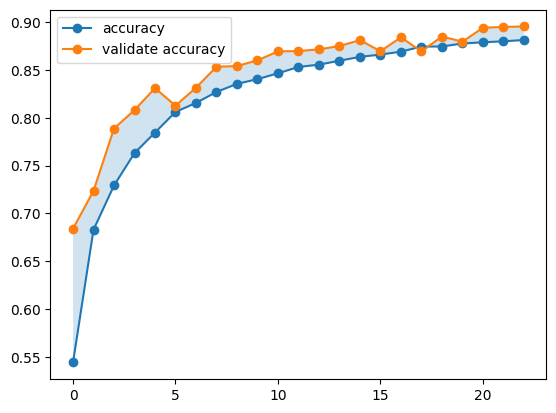

In [9]:
plt.plot(history.history['accuracy'], marker='o', label='accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='validate accuracy')
plt.fill_between(range(len(history.history['accuracy'])), history.history['accuracy'], history.history['val_accuracy'], alpha=0.2)
plt.legend()

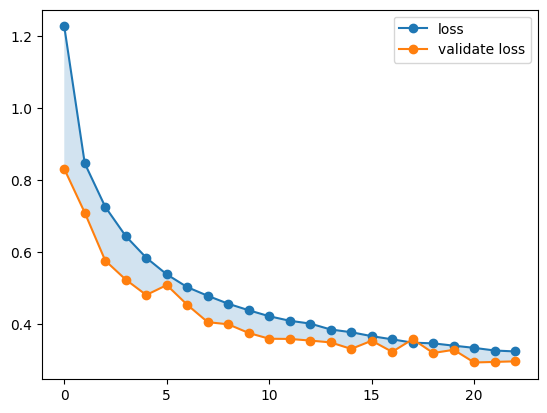

In [10]:
plt.plot(history.history['loss'], marker='o', label='loss')
plt.plot(history.history['val_loss'], marker='o', label='validate loss')
plt.fill_between(range(len(history.history['loss'])), history.history['loss'], history.history['val_loss'], alpha=0.2)
plt.legend()

Стану перенавчання не спостерігається. Є сенс донавчити мережу. Але ознаки в шарі "block1" мали вже сформуватися - його навчати не будемо.

In [13]:
set_trainable = True
for layer in like_vgg16.layers:
    if layer.name == "block1_conv1":
        set_trainable = False
    elif layer.name == "block2_conv1":
        set_trainable = True
    layer.trainable = set_trainable
like_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block0_flip (RandomFlip)    (None, 28, 28, 1)         0         
                                                                 
 block0_rot (RandomRotation  (None, 28, 28, 1)         0         
 )                                                               
                                                                 
 block1_conv1 (Conv2D)       (None, 28, 28, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 28, 28, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 14, 14, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 14, 14, 128)       73856     
                                                        

In [14]:
checkpointer = ModelCheckpoint(filepath=SAVED_BEST_MODEL, verbose=1, save_best_only=True)
history1 = like_vgg16.fit(x_train,
         y_train,          
         batch_size=BATCH_SIZE,
         epochs=EPOCHS_AMO,
         validation_data=(x_valid, y_valid),
         callbacks=[checkpointer])

Epoch 1/23
375/375 [==============================] - ETA: 0s - loss: 0.3093 - accuracy: 0.8875
Epoch 1: val_loss improved from inf to 0.29132, saving model to best_like_vgg16_model.hdf5
375/375 [==============================] - 535s 1s/step - loss: 0.3093 - accuracy: 0.8875 - val_loss: 0.2913 - val_accuracy: 0.8942
Epoch 2/23
375/375 [==============================] - ETA: 0s - loss: 0.3075 - accuracy: 0.8884
Epoch 2: val_loss did not improve from 0.29132
375/375 [==============================] - 709s 2s/step - loss: 0.3075 - accuracy: 0.8884 - val_loss: 0.3168 - val_accuracy: 0.8855
Epoch 3/23
375/375 [==============================] - ETA: 0s - loss: 0.3026 - accuracy: 0.8907
Epoch 3: val_loss improved from 0.29132 to 0.28458, saving model to best_like_vgg16_model.hdf5
375/375 [==============================] - 677s 2s/step - loss: 0.3026 - accuracy: 0.8907 - val_loss: 0.2846 - val_accuracy: 0.8980
Epoch 4/23
375/375 [==============================] - ETA: 0s - loss: 0.2981 - accu

In [63]:
h_accuracy = history.history['accuracy'].copy()
h_accuracy.extend(history1.history['accuracy'])
h_val_accuracy = history.history['val_accuracy'].copy()
h_val_accuracy.extend(history1.history['val_accuracy'])
h_loss = history.history['loss'].copy()
h_loss.extend(history1.history['loss'])
h_val_loss = history.history['val_loss'].copy()
h_val_loss.extend(history1.history['val_loss'])
len(h_accuracy), len(h_val_accuracy), len(h_loss), len(h_val_loss)

(46, 46, 46, 46)

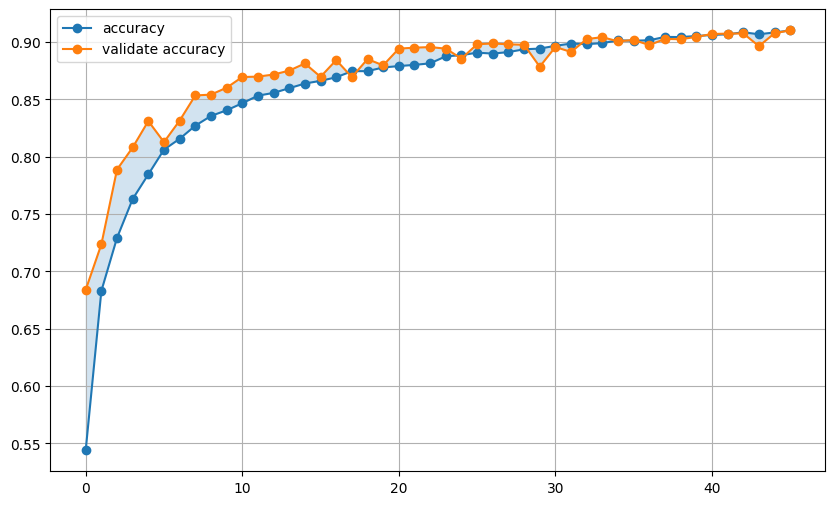

In [68]:
plt.figure(figsize=(10,6))
plt.plot(h_accuracy, marker='o', label='accuracy')
plt.plot(h_val_accuracy, marker='o', label='validate accuracy')
plt.fill_between(range(len(h_accuracy)), h_accuracy, h_val_accuracy, alpha=0.2)
plt.grid()
plt.legend()
plt.show()

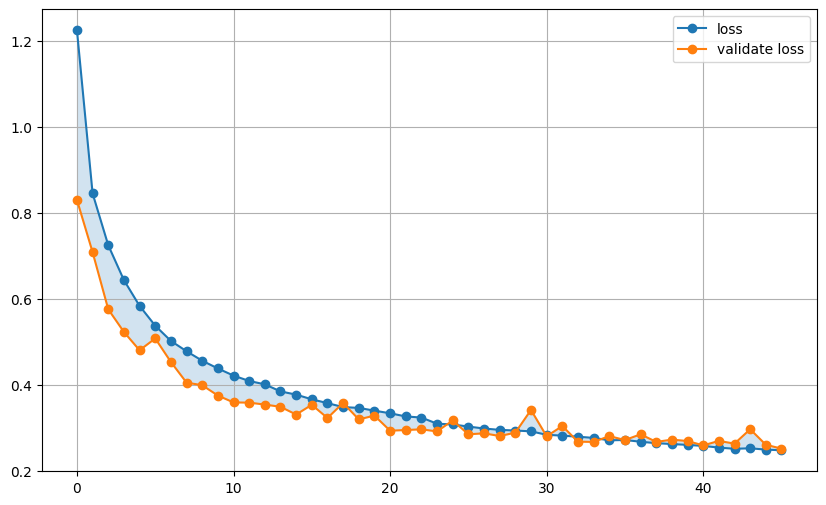

In [69]:
plt.figure(figsize=(10,6))
plt.plot(h_loss, marker='o', label='loss')
plt.plot(h_val_loss, marker='o', label='validate loss')
plt.fill_between(range(len(h_loss)), h_loss, h_val_loss, alpha=0.2)
plt.grid()
plt.legend()
plt.show()

Є гарна сходимість, але перенавчання ще немає. Продовжимо навчання моделі (хоч це і довго).

In [70]:
checkpointer = ModelCheckpoint(filepath=SAVED_BEST_MODEL, verbose=1, save_best_only=True)
history2 = like_vgg16.fit(x_train,
         y_train,          
         batch_size=BATCH_SIZE,
         epochs=EPOCHS_AMO,
         validation_data=(x_valid, y_valid),
         callbacks=[checkpointer])

Epoch 1/23
375/375 [==============================] - ETA: 0s - loss: 0.2429 - accuracy: 0.9107
Epoch 1: val_loss improved from inf to 0.26325, saving model to best_like_vgg16_model.hdf5
375/375 [==============================] - 532s 1s/step - loss: 0.2429 - accuracy: 0.9107 - val_loss: 0.2633 - val_accuracy: 0.9038
Epoch 2/23
375/375 [==============================] - ETA: 0s - loss: 0.2415 - accuracy: 0.9107
Epoch 2: val_loss improved from 0.26325 to 0.25487, saving model to best_like_vgg16_model.hdf5
375/375 [==============================] - 731s 2s/step - loss: 0.2415 - accuracy: 0.9107 - val_loss: 0.2549 - val_accuracy: 0.9098
Epoch 3/23
375/375 [==============================] - ETA: 0s - loss: 0.2389 - accuracy: 0.9123
Epoch 3: val_loss did not improve from 0.25487
375/375 [==============================] - 706s 2s/step - loss: 0.2389 - accuracy: 0.9123 - val_loss: 0.2554 - val_accuracy: 0.9069
Epoch 4/23
375/375 [==============================] - ETA: 0s - loss: 0.2354 - accu

In [71]:
h_accuracy = history.history['accuracy'].copy()
h_accuracy.extend(history1.history['accuracy'])
h_accuracy.extend(history2.history['accuracy'])
h_val_accuracy = history.history['val_accuracy'].copy()
h_val_accuracy.extend(history1.history['val_accuracy'])
h_val_accuracy.extend(history2.history['val_accuracy'])
h_loss = history.history['loss'].copy()
h_loss.extend(history1.history['loss'])
h_loss.extend(history2.history['loss'])
h_val_loss = history.history['val_loss'].copy()
h_val_loss.extend(history1.history['val_loss'])
h_val_loss.extend(history2.history['val_loss'])
len(h_accuracy), len(h_val_accuracy), len(h_loss), len(h_val_loss)

(69, 69, 69, 69)

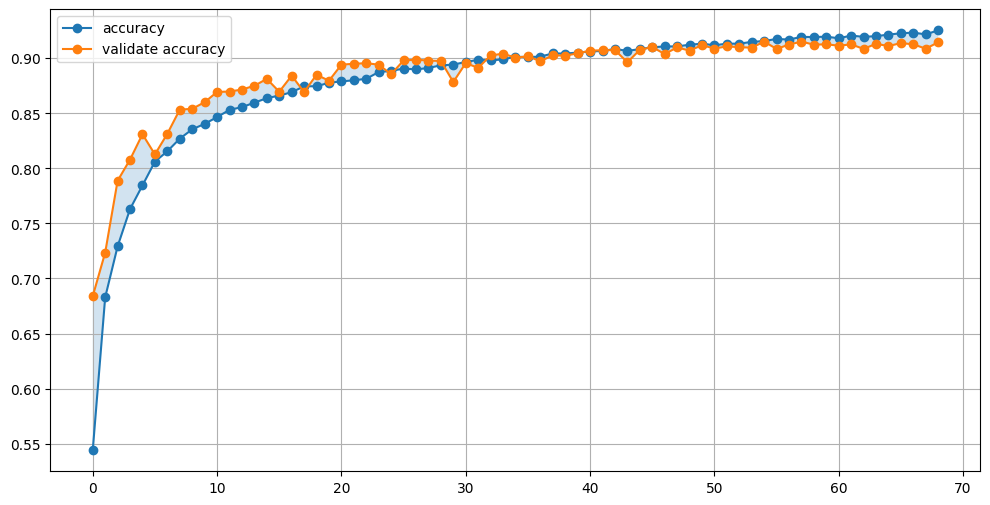

In [73]:
plt.figure(figsize=(12,6))
plt.plot(h_accuracy, marker='o', label='accuracy')
plt.plot(h_val_accuracy, marker='o', label='validate accuracy')
plt.fill_between(range(len(h_accuracy)), h_accuracy, h_val_accuracy, alpha=0.2)
plt.grid()
plt.legend()
plt.show()

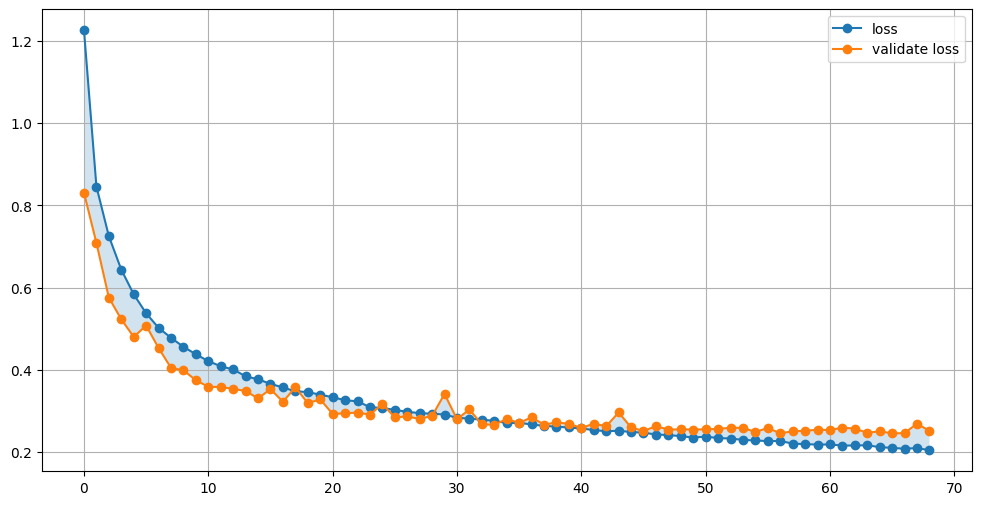

In [75]:
plt.figure(figsize=(12,6))
plt.plot(h_loss, marker='o', label='loss')
plt.plot(h_val_loss, marker='o', label='validate loss')
plt.fill_between(range(len(h_loss)), h_loss, h_val_loss, alpha=0.2)
plt.grid()
plt.legend()
plt.show()

Зараз видно, що модель почала перенавчатися.

In [76]:
like_vgg16.load_weights(SAVED_BEST_MODEL)

In [77]:
score = like_vgg16.evaluate(x_train, y_train)
print(f'[*] Test accuracy with TRAIN images: {round(score[1]*100, 2)}%')

1500/1500 [==============================] - 93s 62ms/step - loss: 0.1900 - accuracy: 0.9291
[*] Test accuracy with TRAIN images: 92.91%


In [78]:
score = like_vgg16.evaluate(x_test, y_test)
print(f'[*] Test accuracy with TEST images: {round(score[1]*100, 0)}%')

313/313 [==============================] - 25s 81ms/step - loss: 0.2473 - accuracy: 0.9129
[*] Test accuracy with TEST images: 91.0%


# Візуалізація результату

In [79]:
probability_model = tf.keras.Sequential([like_vgg16,  tf.keras.layers.Softmax()])
predictions = probability_model.predict(x_test)

313/313 [==============================] - 21s 64ms/step


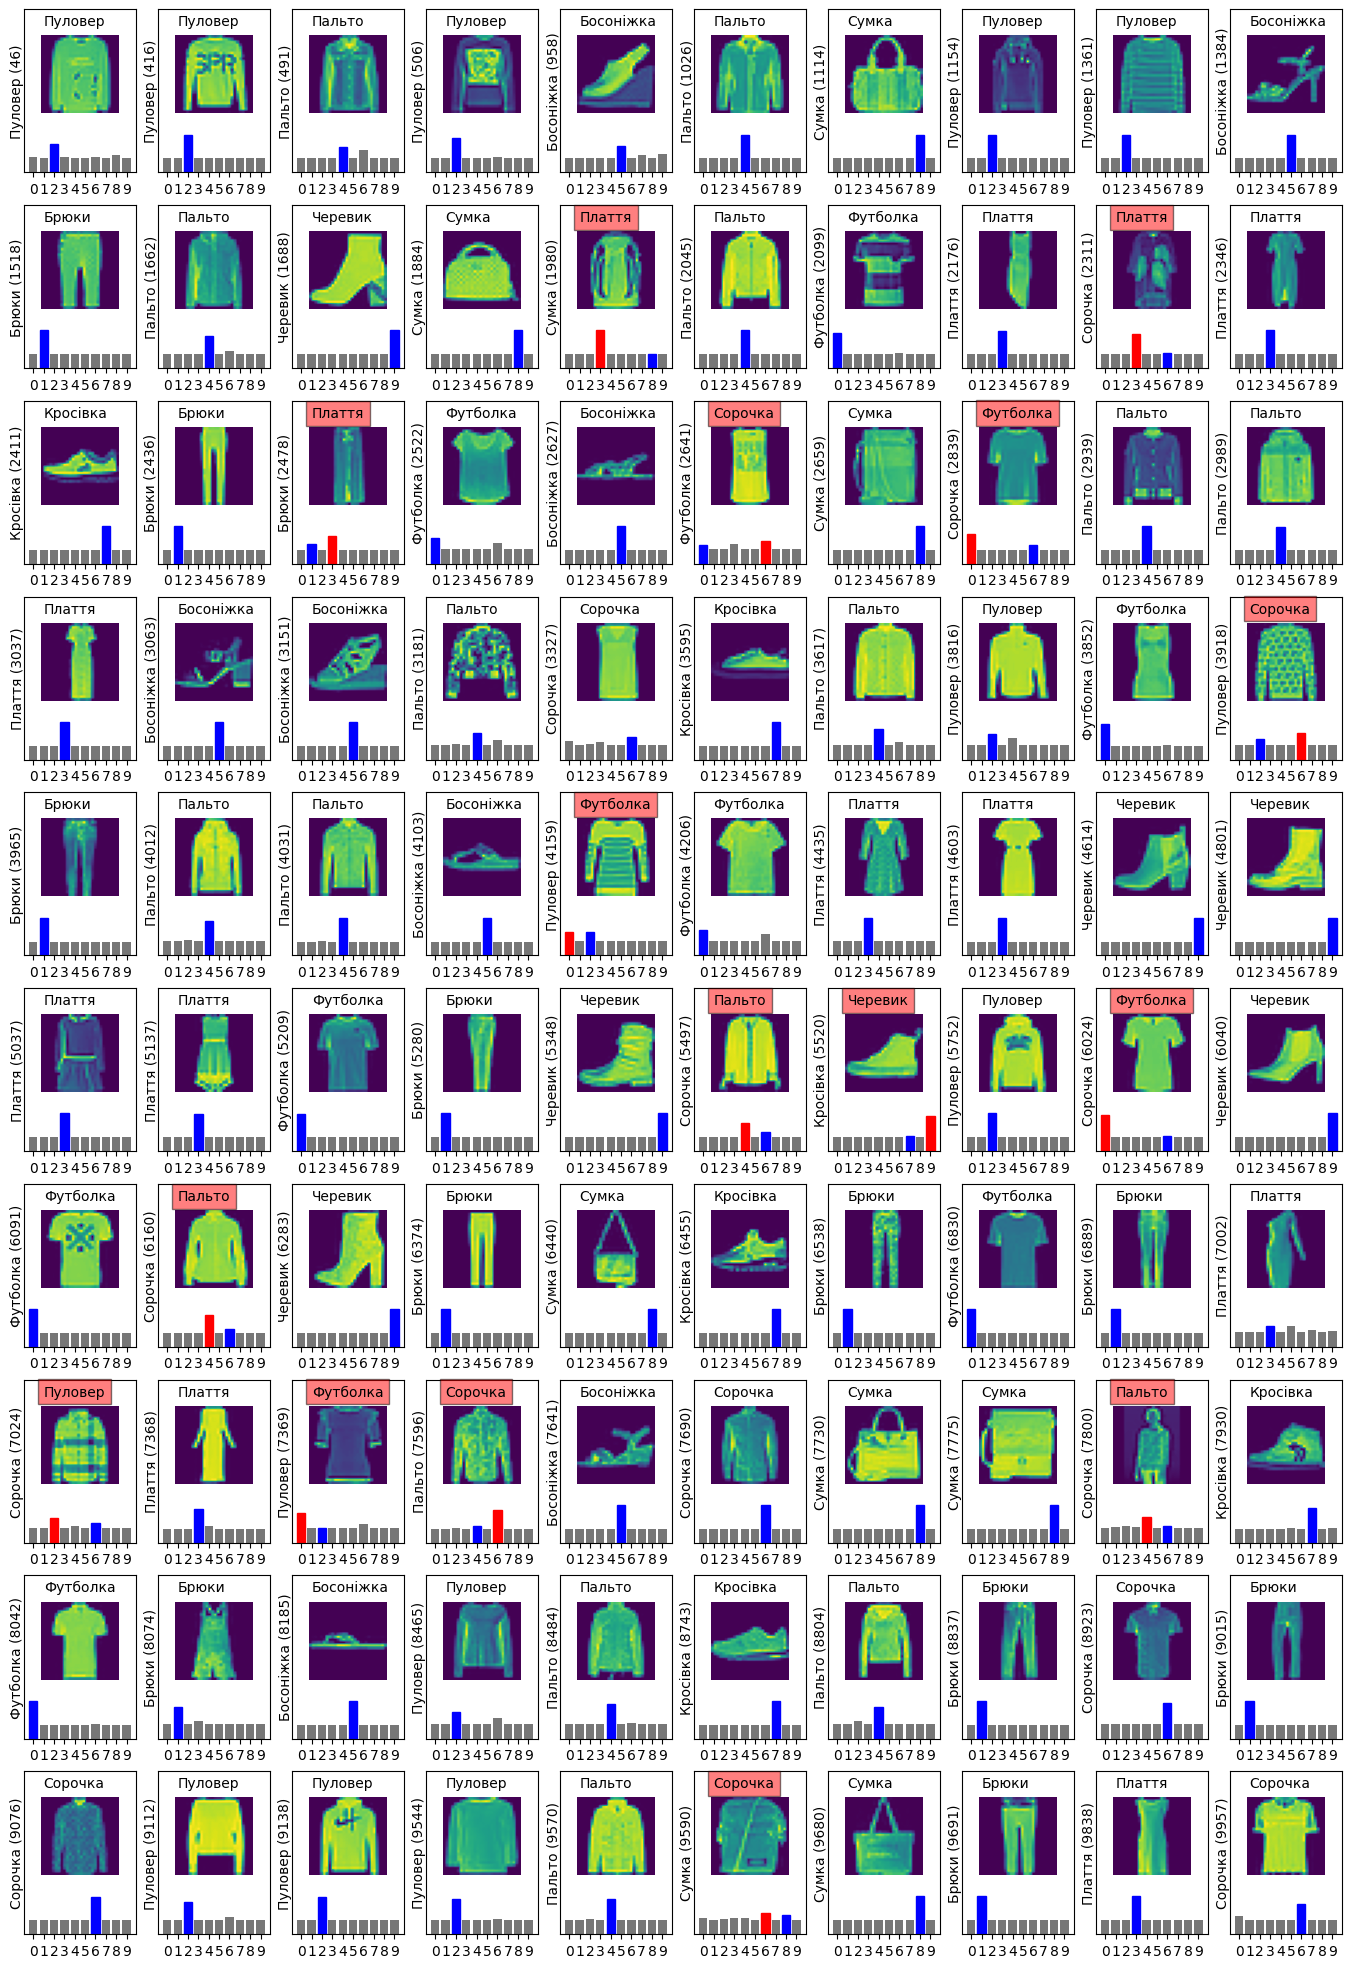

In [80]:
def indices(arr, size, sizemax):
    assert size <= sizemax
    rest = size - len(arr)
    if rest <= 0:
        return np.array(arr[:size])
    arr = np.unique(np.concatenate((np.array(arr),
                                    np.random.randint(0, sizemax, size=rest, dtype=int))))
    while len(arr) < size:
        arr = np.unique(np.concatenate((arr,
                                        np.random.randint(0, sizemax, size=size-len(arr), dtype=int))))
    return arr

plt.figure(figsize=(17,25))
i = 0
for ind in indices(BAD_TEST_CASES, 100, y_test.shape[0]):
    y_predict_ind = np.argmax(predictions[ind])
    y_predict = CLASS_NAMES[y_predict_ind]
    y_actual_ind = np.argmax(y_test[ind])
    y_actual = CLASS_NAMES[y_actual_ind]
    bbox = None
    if y_actual_ind != y_predict_ind:
        bbox = dict(facecolor='red', alpha=0.5)
    img = x_test[ind]
    # Show image and bars of classification
    i += 1
    fig = plt.subplot(10,10,i)
    imagebox = OffsetImage(img, zoom = 2)
    fig.axes.add_artist(AnnotationBbox(imagebox, (4.5,0.6), frameon = False))
    plt.grid(False)
    plt.xticks(range(len(CLASS_NAMES)))
    plt.yticks([])
    thisplot = plt.bar(range(len(CLASS_NAMES)), predictions[ind], color="#777777", alpha=1)
    plt.ylim([0, 1])
    plt.ylabel(f"{y_actual} ({ind})", labelpad=0)
    thisplot[y_predict_ind].set_color('red')
    thisplot[y_actual_ind].set_color('blue')
    plt.text(x=1, y=0.9, s=y_predict, bbox=bbox)

plt.show()

**Висновок:**
-
Попередня більш проста модель зі _408104_ параметрами за _20 епох_ за _3677сек = 1год 1хв 17сек_ досягла точності _0.9162_. Подібна VGG16 модель зі _2919626_ параметрами за _92 епохи_ за _приблизно 13год_ досягла майже тої самої точності точності _0.9129_. Але подібна VGG16 модель **потребує у 7 разів більше пам'яті, ніж попередня більш проста модель**, і, відповідно, передбачення займають більше часу. Але подібна VGG16 модель є **більш стійкою до симетричних перетворень та поворотів**, ніж більш проста модель, що важливо у більшості випадків. З іншого боку, людина здатна правильно класифікувати зображення з точністю десь 0.94, тобто обидві моделі все одно гірші за людину. Тому, можливо, варто подумати, як покращити модель.